# parPE Lucarelli example model

In [16]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
sbml_file = 'lucarelli_12.xml'
model_name = 'lucarelli_12'
model_output_dir = 'lucarelli_12'

In [18]:
# Show model info
import libsbml
SBMLreader = libsbml.SBMLReader()
sbml_doc = SBMLreader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('Parameters: ', [p.getId() for p in sbml_model.getListOfParameters()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['TGFb', 'Rec', 'TGFb_pRec', 'S2', 'S3', 'S4', 'S2_S4_S4', 'ppS2_ppS2_ppS2', 'ppS3_ppS3_ppS3', 'S4_S4_S4', 'pS2', 'pS3', 'ppS2', 'ppS3', 'ppS2_ppS2_S4', 'ppS2_ppS2_ppS3', 'ppS2_ppS3_ppS3', 'ppS3_ppS3_S4', 'ppS2_ppS3_S4', 'ppS3_S4_S4', 'ppS2_S4_S4', 'geneA', 'geneB', 'geneC', 'geneD', 'geneE', 'geneF', 'geneG', 'geneH', 'geneI', 'geneJ', 'geneK', 'geneL']
Parameters:  ['Rec_act', 'S_dephos', 'S_dephosphos', 'S_phos', 'geneA_act1', 'geneA_act2', 'geneA_act3', 'geneA_inh1', 'geneA_inh2', 'geneA_inh3', 'geneA_turn', 'geneB_act1', 'geneB_act2', 'geneB_act3', 'geneB_inh1', 'geneB_inh2', 'geneB_inh3', 'geneB_turn', 'geneC_act1', 'geneC_act2', 'geneC_act3', 'geneC_inh1', 'geneC_inh2', 'geneC_inh3', 'geneC_turn', 'geneD_act1', 'geneD_act2', 'geneD_act3', 'geneD_inh1', 'geneD_inh2', 'geneD_inh3', 'geneD_turn', 'geneE_act1', 'geneE_act2', 'geneE_act3', 'geneE_inh1', 'geneE_inh2', 'geneE_inh3', 'geneE_turn', 'geneF_act1', 'geneF_act2', 'geneF_act3', 'geneF_inh1', 'geneF_inh2', 'geneF_inh

## Generate model code

In [19]:
# remove time from the list of names
observables_list = ['observable_Ski', 'observable_Skil', 'observable_Dnmt3a', 'observable_Sox4', 'observable_Jun', 'observable_Smad7', 'observable_Klf10', 'observable_Bmp4', 'observable_Cxcl15', 'observable_Dusp5', 'observable_Tgfa', 'observable_Pdk4'] #
fixed_parameters = ['init_TGFb', 'init_S2', 'init_S3', 'init_S4']

def createModule(sbml_model_file, model_name, model_output_dir):
    """Create Python module from SBML model"""
    sbmlImporter = amici.SbmlImporter(sbml_model_file)
    sbml = sbmlImporter.sbml
    global observables
    observables = amici.assignmentRules2observables(
                  sbmlImporter.sbml, # the libsbml model object
                  filter=lambda variableId: variableId in observables_list)

    sbmlImporter.sbml2amici(model_name,
                            output_dir=model_output_dir,
                            observables=observables,
                            constantParameters=fixed_parameters)


In [20]:
createModule(sbml_file, model_name, model_output_dir)

libSBML Warning (SBML unit consistency): In situations where a mathematical expression contains literal numbers or parameters whose units have not been declared, it is not possible to verify accurately the consistency of the units in the expression. 
 The units of the <initialAssignment> <math> expression 'init_Rec' cannot be fully checked. Unit consistency reported as either no errors or further unit errors related to this object may not be accurate.

libSBML Warning (SBML unit consistency): In situations where a mathematical expression contains literal numbers or parameters whose units have not been declared, it is not possible to verify accurately the consistency of the units in the expression. 
 The units of the <initialAssignment> <math> expression 'init_TGFb' cannot be fully checked. Unit consistency reported as either no errors or further unit errors related to this object may not be accurate.

libSBML Warning (SBML unit consistency): In situations where a mathematical expressio

## Test simulation

In [21]:
def plotStateTrajectories(rdata):
    for ix in range(22,33):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


[5.98343089e-03 2.86397320e-01 4.89949146e-02 3.79720143e-01
 1.41389661e-02 7.97280888e-04 0.00000000e+00 0.00000000e+00
 4.62523982e-02 2.63810590e-02 4.55788978e-03 4.61699171e-01
 7.38527752e-02 3.04255474e-02 0.00000000e+00 7.47200750e-01
 4.07329851e-01 1.12459405e-02 7.14636599e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.84415822e-02 3.53796933e-02
 3.78630405e-03 1.11673720e-02 2.68942133e-04 0.00000000e+00
 0.00000000e+00 8.68803386e-02 1.01419106e-01 8.02160834e-04
 0.00000000e+00 1.03661056e+00 6.10224670e+00 8.20035989e+00
 1.43925487e+00 9.67035015e+00 1.24380539e-01 9.98299920e+02
 1.35655044e-01 2.06442242e+01 3.63157062e+00 0.00000000e+00
 0.00000000e+00 3.66724104e+01 6.26768522e+02 5.59534538e+01
 0.00000000e+00 0.00000000e+00 1.75854489e-02 8.15621976e-04
 2.95971428e+02 0.00000000e+00 8.99866383e+01 9.99921986e+02
 9.99998961e+02 1.90317907e+01 2.18356691e+02 9.92827361e-01
 9.30152789e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.20763519e+02 9.999816

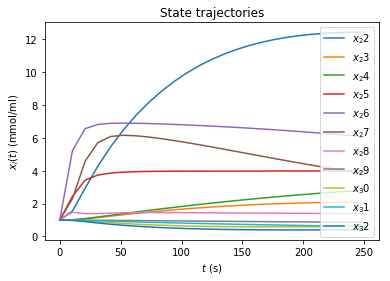

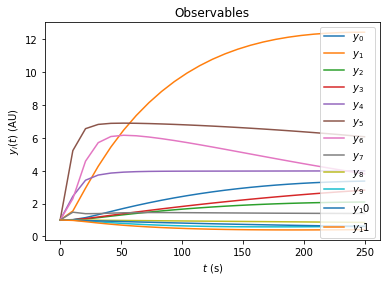

In [22]:
# load model
sys.path.insert(0, model_output_dir)
import lucarelli_12 as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 250, 25))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Create in silico experimental data for parameter estimation

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [27]:
from pandas import DataFrame

def createConditionDataframe(indices, conditions, parameters):
    """Create dataframe with fixed-parameters for each condition to simulate"""
    conditionDf = pd.DataFrame(index=indices)
    conditionDf['ID'] = conditionDf.index
    for icondition, condition in enumerate(conditions):
        conditionDf['condition-%d' % icondition] = condition
    
    return conditionDf

def getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay):
    model.setParameters(amici.DoubleVector(simulationParameters))
    
    # simulate without measurements
    edata = amici.ExpData(model.get())
    edata.fixedParameters = amici.DoubleVector(condition)
    edata.my = amici.DoubleVector(np.full(shape=model.nt() * model.nytrue, fill_value=np.nan))
    rdata = amici.runAmiciSimulation(model, solver, edata)        
    # fixedParametersPreequilibration = 

    # confirm gradient is 0 for real measurements and save expected llh
    measurement = rdata['y']
    measurement = np.random.normal(loc=rdata['y'], scale=sigmay)
    measurement = np.random.normal(
        loc=rdata['y'], 
        scale=sigmay[0][0])
    # print(measurement)

    edata.my = amici.DoubleVector(measurement.flatten())
    edata.sigmay = amici.DoubleVector(sigmay.flatten())
    model.requireSensitivitiesForAllParameters()
    rdata = amici.runAmiciSimulation(model, solver, edata)
    # return generated noisy measurents
    rdata['y'] = measurement
    return rdata

expectedLlh = 0.0
sigma_default = 0.1 # parameters are lin
timepoints = np.linspace(0, 100, 5)

model = modelModule.getModel()
true_parameters = np.array(model.getParameters())

# setup model & solver
model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(timepoints))
model.setParameters(amici.DoubleVector(true_parameters))

solver = model.getSolver()
solver.setMaxSteps(10000)

# generate conditon-vectors
sigma = 0.5
mu = 1.5
nConditions = 10
init_TGFb = np.linspace(0,1,11)
init_conditions = [10.0**(mu + sigma * np.random.randn(4))]
init_conditions[0][0] = init_TGFb[np.random.randint(0,11)]
for i in range(1,nConditions):
    init_conditions.append(np.array(10.0**(mu + sigma * np.random.randn(4))))
    init_conditions[i][0] = init_TGFb[np.random.randint(0,11)]
    
indices = fixed_parameters
conditionDf = createConditionDataframe(indices, init_conditions, true_parameters)
    
df = pd.DataFrame(data={
    'observable': [],
    'condition': [],
    'conditionRef': [],
    'time': [],
    'measurement': [],
})

for icondition, condition in enumerate(init_conditions):      
    
    simulationParameters = true_parameters
    sigmay = np.ones(shape=(model.nt(), model.nytrue)) * sigma_default
    
    # simulate condition
    rdata = getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay)

    expectedLlh += rdata['llh']
    
    conditionName = 'condition-%d' % icondition
    
    # Append data
    for iy, observableName in enumerate(observables.keys()):
        scalingParameter = [''] 
        sigma = sigmay[:, iy]
        
        df = df.append(pd.DataFrame(
        {'observable'      : [observableName] * model.nt(),
         'condition'       : [conditionName]  * model.nt(),
         'conditionRef'    : ['']  * model.nt(),
         'scalingParameter': scalingParameter * model.nt(),
         'time'            : np.array(model.getTimepoints()),
         'measurement'     : rdata['y'][:, iy],
         'sigma'           : sigma
         }), ignore_index=True)
print('Expected llh: ', expectedLlh)

/home/paul/.local/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Expected llh:  0.0


In [29]:
conditionDf

,ID,condition-0,condition-1,condition-2,condition-3,condition-4,condition-5,condition-6,condition-7,condition-8,condition-9
init_TGFb,init_TGFb,0.600000,0.900000,0.200000,0.000000,0.900000,0.600000,0.100000,0.500000,0.600000,0.300000
init_S2,init_S2,152.006364,130.889282,66.796665,35.658869,22.467817,41.494741,50.944518,45.472211,7.796680,210.442291
init_S3,init_S3,16.850367,106.592633,26.987028,64.060959,70.657679,29.766273,15.119838,9.071958,19.688133,6.270153
init_S4,init_S4,29.724351,12.165804,12.066450,29.944685,96.131126,16.511862,142.163063,41.967654,129.919691,61.452265


In [28]:
df

,condition,conditionRef,measurement,observable,scalingParameter,sigma,time
0,condition-0,,0.956718,observable_Ski,,0.1,0.0
1,condition-0,,1.225612,observable_Ski,,0.1,25.0
2,condition-0,,1.572359,observable_Ski,,0.1,50.0
3,condition-0,,1.901191,observable_Ski,,0.1,75.0
4,condition-0,,2.569625,observable_Ski,,0.1,100.0
5,condition-0,,0.946144,observable_Skil,,0.1,0.0
6,condition-0,,3.424374,observable_Skil,,0.1,25.0
7,condition-0,,6.222071,observable_Skil,,0.1,50.0
8,condition-0,,8.166124,observable_Skil,,0.1,75.0
9,condition-0,,9.896684,observable_Skil,,0.1,100.0


In [9]:
# write data frames to file
measurement_file = 'example_data.tsv'
fixed_parameter_file = 'example_data_fixed.tsv'
hdf5File = 'example_data.h5'

df.to_csv(measurement_file, sep='\t', index=False)
conditionDf.to_csv(fixed_parameter_file, sep='\t', index=False)

! /bin/bash -c "if [[ -f example_data.h5 ]]; then cp example_data.h5 example_data.h5.bak; fi"
# convert to HDF5
import subprocess
out = subprocess.run(['%s/generateHDF5DataFileFromText.py' % os.path.join(os.getcwd(), '..', '..', '..', 'misc'),
    hdf5File,
    sbml_file,
    model_output_dir,
    measurement_file,
    fixed_parameter_file], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(out.stdout.decode("utf-8"))
print(out.returncode)


Measurements shape (600, 7)
Changing t = Inf to t = 1e8.
Num conditions:  10
Num timepoints:  5 [0.0, 25.0, 50.0, 75.0, 100.0]
Fixed parameters orginal:  (4, 10)
Fixed parameters usable:  (4, 10)
Generate parameter list...
Number of simulation parameters: 114
Number of optimization parameters: 114
Generating fixed parameters matrix...
Number of fixed parameters: 4
Generating measurement matrix...
Number of observables: 12
Handling scaling parameters...
Copying default AMICI options...
Writing default optimization options...

0


In [10]:
# write true parameters as first starting point, an perturbed additional points
# two times the same point to check for reproducibility
import h5py
with h5py.File(hdf5File, 'r+') as f:
    pscale = f['/parameters/pscale'][:]
    true_parameters_scaled = true_parameters.copy()
    for i, p in enumerate(pscale):
        if p == 2:
            if true_parameters[i] < 1e-10:
                true_parameters_scaled[i] = -10.0
            else:
                true_parameters_scaled[i] = np.log10(true_parameters[i])
    
    print(true_parameters_scaled)
    
    for i in range(10):
        parameters = true_parameters_scaled
        #parameters = parameters + np.random.normal(0.0, 0.2 + i * 0.1, true_parameters.shape)
        #parameters = np.random.uniform(-3, 5, true_parameters.shape)
        
        #print(parameters)
        f['/optimizationOptions/randomStarts'][:,2*i]   = parameters
        f['/optimizationOptions/randomStarts'][:,2*i+1] = parameters


[-2.22304972e+00 -5.43031050e-01 -1.30984899e+00 -4.20536365e-01
 -1.84958235e+00 -3.09838865e+00 -1.00000000e+01 -1.00000000e+01
 -1.33486574e+00 -1.57870777e+00 -2.34123618e+00 -3.35640905e-01
 -1.13163318e+00 -1.51676160e+00 -1.00000000e+01 -1.26562701e-01
 -3.90053761e-01 -1.94900422e+00 -2.14591475e+00 -1.00000000e+01
 -1.00000000e+01 -1.00000000e+01 -1.73420182e+00 -1.45124594e+00
 -2.42178451e+00 -1.95204902e+00 -3.57034116e+00 -1.00000000e+01
 -1.00000000e+01 -1.06107850e+00 -9.93880223e-01 -3.09573855e+00
 -1.00000000e+01  1.56156269e-02  7.85489761e-01  9.13832913e-01
  1.58137708e-01  9.85442200e-01 -9.05247566e-01  2.99926104e+00
 -8.67564055e-01  1.31479857e+00  5.60094493e-01 -1.00000000e+01
 -1.00000000e+01  1.56433946e+00  2.79710718e+00  1.74782690e+00
 -1.00000000e+01 -1.00000000e+01 -1.75484654e+00 -3.08851108e+00
  2.47124979e+00 -1.00000000e+01  1.95417803e+00  2.99996612e+00
  2.99999955e+00  1.27947965e+00  2.33916650e+00 -3.12626267e-03
  9.68554293e-01 -1.00000

In [11]:
# enable derivate checker
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test first-order
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test_print_all yes
!../../../misc/optimizationOptions.py example_data.h5 -s numStarts 5
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                               numStarts            5
                       retryOptimization            1
                hierarchicalOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

## Gradient check

## Optimize

In [30]:
!pwd
!(cd ../../../build && exec make -j12)
!../../../build/amici/examples/lucarelli/example_lucarelli_multi -o deleteme/ example_data.h5


/home/paul/Documents/parpe/parPE/amici/examples/lucarelli
[  7%] Built target parpecommon
[  8%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/wrapfunctions.cpp.o
-- Found Git: /usr/bin/git (found version "2.17.1") 
-- Building version parPE-v0.1.8-5-gc0c11-dirty
Scanning dependencies of target parpeoptimization
[  8%] Built target get_version
[ 12%] Built target unittests_common
[ 14%] Built target parpeloadbalancer
[ 15%] Building CXX object optimization/src/CMakeFiles/parpeoptimization.dir/optimizationResultWriter.cpp.o
[ 17%] Built target example_loadbalancer
[ 20%] Built target unittests_loadbalancer
In file included from /home/paul/Documents/parpe/parPE/amici/examples/steadystate/model_steadystate_scaled/wrapfunctions.h:3:0,
                 from /home/paul/Documents/parpe/parPE/amici/examples/steadystate/model_steadystate_scaled/wrapfunctions.cpp:2:
/home/paul/Documents/parpe/parPE/amici/examples/steadystate/model

In [14]:
for i in range(3):
    !PARPE_NO_DEBUG=1 ../../../build/amici/examples/lucarelli/example_lucarelli_multi -t gradient_check -o deletemegc/ example_data.h5


/bin/sh: 1: ../../../build/amici/examples/lucarelli/example_lucarelli_multi: not found
/bin/sh: 1: ../../../build/amici/examples/lucarelli/example_lucarelli_multi: not found
/bin/sh: 1: ../../../build/amici/examples/lucarelli/example_lucarelli_multi: not found


In [ ]:
filename = 'deleteme/_rank-0001.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
trajectory

## Compare results

In [ ]:
def compareResults(filename, expectedNllh):
    with h5py.File(filename, 'r') as f:
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp___ __Act___ __Err___ _RelErr___")
    for i in range(len(true_parameters)):
        error = final_parameters[i]-true_parameters[i]
        rel_error = error / true_parameters[i]
        print('%d: %6f %6f %6f %6f' % (i, true_parameters[i], 
                                       final_parameters[i], 
                                       error,rel_error))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [ ]:
compareResults('deleteme/_rank-0001.h5', -expectedLlh)

In [ ]:
!pwd

In [ ]:
!rm sim.h5
!../../../build/amici/examples/lucarelli/example_lucarelli_multi_simulator deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

In [ ]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

In [ ]:
def plotCorrelation(ymes, ysim):
    for iy in range(ysim.shape[2]):
        fig, ax = plt.subplots()
        for icondition in range(ysim.shape[0]):
            x = ymes[icondition, :, iy]
            y = ysim[icondition, :, iy]
            print(x, y)
            ax.scatter(x, y, label='$y_%d$ condition %d' % (iy, icondition))
        plt.xlabel('measurement (AU)')
        plt.ylabel('simulation (AU)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Observable %d' % iy)
        plt.legend()
        plt.show()
        
plotCorrelation(ymes, ysim)

In [ ]:
def plotTrajectoryFit(ymes, ysim, timepoints):
    for icondition in range(ysim.shape[0]):
        fig, ax = plt.subplots()
        for iy in range(ysim.shape[2]):
            ax.plot(timepoints, ysim[icondition, :, iy], label='$y_%d$ sim' % (iy), alpha=0.7, c='C%d'%iy)
            ax.plot(timepoints, ymes[icondition, :, iy], label='$y_%d$ mes' % (iy), linestyle='dotted', c='C%d'%iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.title('Condition %d' %icondition)
        plt.legend()
        plt.show()

plotTrajectoryFit(ymes, ysim, timepoints)